## Plot chemical species vertical profiles

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

In [2]:
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator

In [3]:
from util_commons import GASES, PLANETS, SUITES
from util_mypaths import path_to_results
from util_plot_func import use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
use_paper_style()

In [5]:
# Parameters
metallicity = "1x solar"
t0 = 80  # 80th slice of 10-day-frequency output, i.e. 800 day
tgt_plevs = np.logspace(7, 2, 65)  # target pressure levels
tgt_lats = [0, 60]  # target latitudes
tgt_lons = np.arange(0, 360, 30) + 1.25  # target longitudes*
interp_args = ([("latitude", tgt_lats), ("longitude", tgt_lons)], iris.analysis.Linear())
sp_names_short = ["ch4", "co", "co2", "h2o", "hcn", "nh3"]
sp_names_long = [f"{sp_name.upper()} mole fraction" for sp_name in sp_names_short]
# *in the UM v11.4 substellar point in radiation is shifted 1.25 degrees east

In [6]:
vrbls = {}
for planet in PLANETS.keys():
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls[planet][exp] = {}
        # Find data
        fpath = SUITES[planet][exp][metallicity]["dir_for_merged"]
        fname = f"{SUITES[planet][exp][metallicity]['rose_suite']}.nc"
        # Load variables
        pres = iris.load_cube(str(fpath / fname), um.pres)[-1, ...]
        _sps = iris.load(str(fpath / fname), sp_names_long)
        sps = iris.cube.CubeList()
        for i in _sps:
            sps.append(i[t0:, ...].collapsed("time", iris.analysis.MEAN))
        # Interpolate species mole fractions to pressure levels
        sps_plevs_locs = iris.cube.CubeList()
        for sp in sps:
            cb_plevs = interp_cube_from_height_to_pressure_levels(sp, pres, tgt_plevs)
            cb_plevs_locs = cb_plevs.interpolate(*interp_args)
            sps_plevs_locs.append(cb_plevs_locs)
        pres_coord = sps_plevs_locs[0].coord("air_pressure")
        # Assemble data
        vrbls[planet][exp] = {
            "sps_plevs_locs": sps_plevs_locs,
        }

In [7]:
# Plotting parameters
# Sample each colormap 4 times but use the brightest 3 colours from each colormap
nclrs = 4
clrs_1 = plt.cm.Blues_r(np.linspace(0, 1, nclrs)[0 : nclrs - 1])
clrs_2 = plt.cm.Oranges(np.linspace(0, 1, nclrs)[1:])
clrs_3 = plt.cm.Reds_r(np.linspace(0, 1, nclrs)[0 : nclrs - 1])
clrs_4 = plt.cm.Greens(np.linspace(0, 1, nclrs)[1:])
lon_clrs = np.concatenate([clrs_1, clrs_2, clrs_3, clrs_4])

alpha_60 = 0.5
lon_clrs_60 = lon_clrs * np.array([1, 1, 1, alpha_60])
leg_lat_kw = {
    "0": {"linestyle": "-", "linewidth": 2, "color": "grey"},
    "60°N": {"linestyle": "-", "linewidth": 2, "color": "grey", "alpha": alpha_60},
}

leg_exp_kw = {
    "Equilibrium": {"linestyle": "--", "linewidth": 2, "color": "k"},
    "Kinetics": {"linestyle": "-", "linewidth": 2, "color": "k"},
}
leg_line_kw = {"equilibrium": {"linestyle": "--"}, "kinetics": {"linestyle": "-"}}

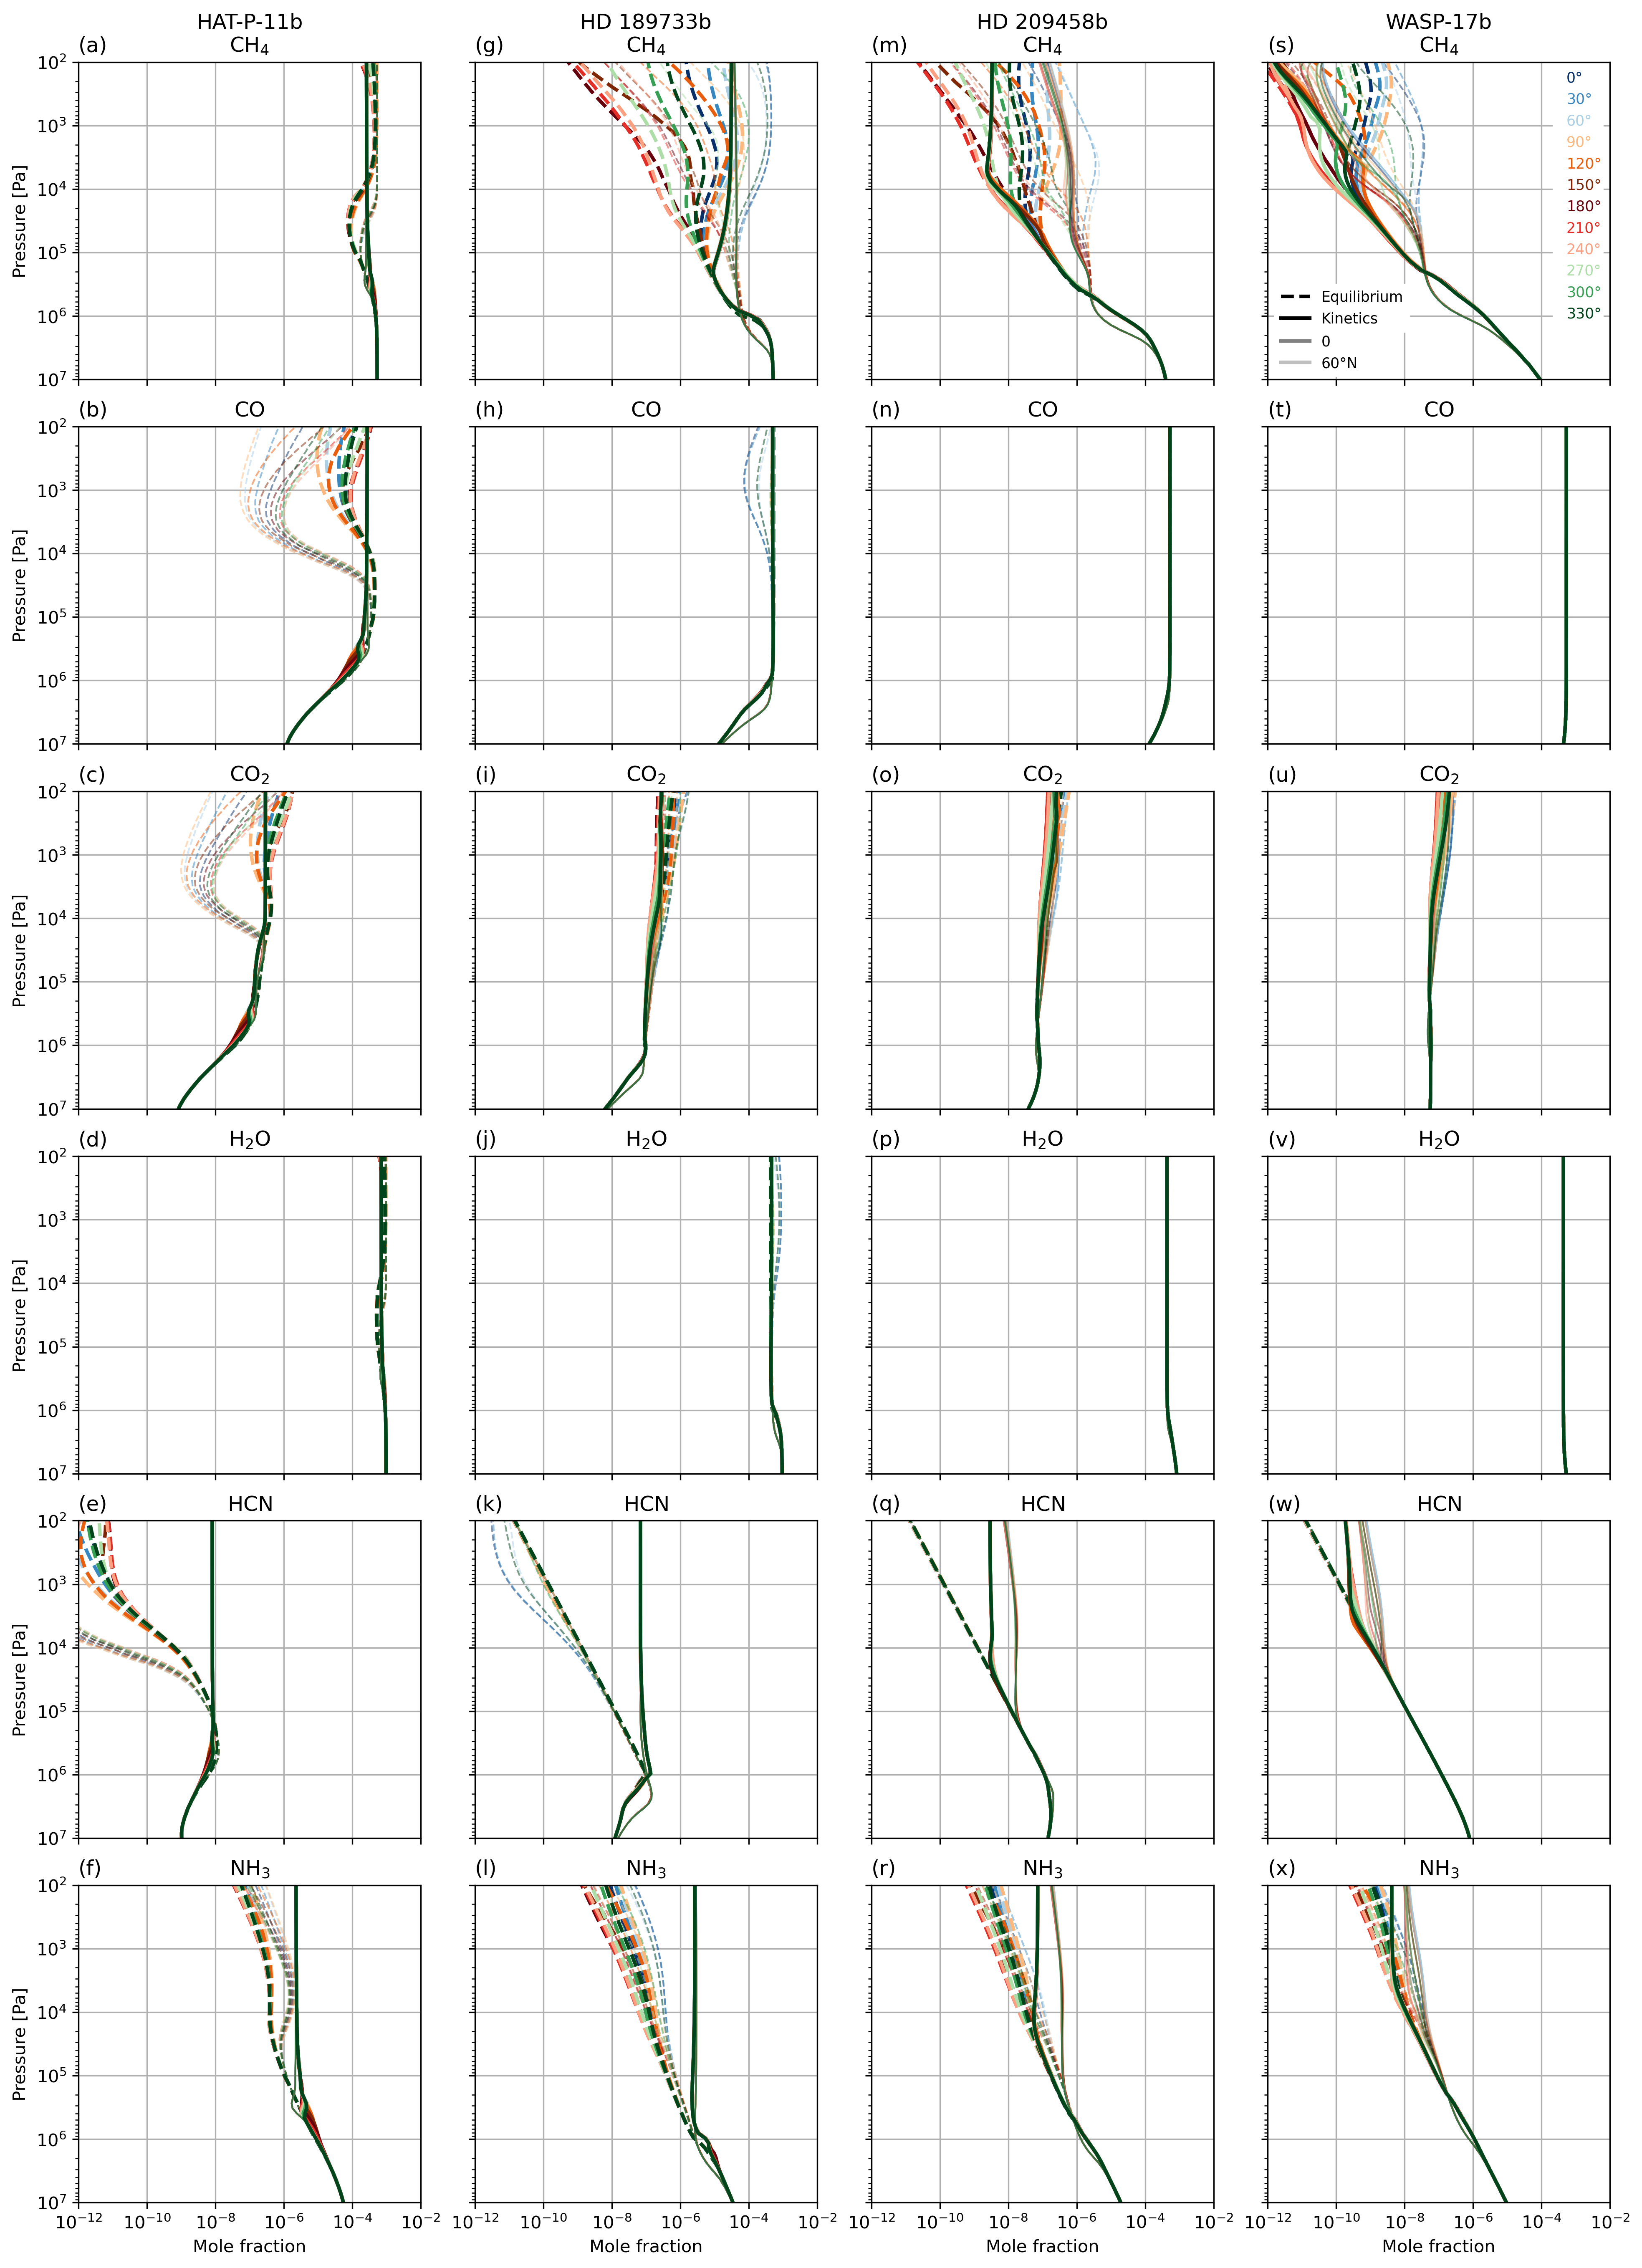

In [8]:
# Plot
fig, axes = plt.subplots(
    ncols=4,
    nrows=len(sp_names_short),
    figsize=(13, 18),
    sharex=True,
    sharey=True,
    facecolor="w",
    constrained_layout=True,
)
iletters = subplot_label_generator()
for planet, axcol in zip(PLANETS.keys(), axes.T):
    for sp, ax in zip(sp_names_short, axcol):
        stash_name = f"{sp.upper()} mole fraction"
        ax.set_title(f"({next(iletters)})", loc="left")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(1e-12, 1e-2)
        ax.set_ylim(1e7, 1e2)
        ax.grid()
        if ax.get_subplotspec().is_first_row():
            ax.set_title(f'{PLANETS[planet]["tex"]}\n{GASES[sp.upper()]["tex"]}', loc="center")
        else:
            ax.set_title(f'{GASES[sp.upper()]["tex"]}', loc="center")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Pressure [Pa]")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Mole fraction")
        for exp, plt_kw in leg_line_kw.items():
            for lon, clr, clr60 in zip(tgt_lons, lon_clrs, lon_clrs_60):
                vp00 = (
                    vrbls[planet][exp]["sps_plevs_locs"]
                    .extract(stash_name)[0]
                    .extract(iris.Constraint(latitude=0, longitude=lon))
                )
                vp60 = (
                    vrbls[planet][exp]["sps_plevs_locs"]
                    .extract(stash_name)[0]
                    .extract(iris.Constraint(latitude=60, longitude=lon))
                )
                ax.plot(
                    vp00.data,
                    pres_coord.points,
                    **plt_kw,
                    color=clr,
                    label=f"{int(lon-1.25)}°",
                    linewidth=2,
                )
                ax.plot(
                    vp60.data,
                    pres_coord.points,
                    **plt_kw,
                    color=clr60,
                    label=f"{int(lon-1.25)}°",
                    linewidth=1,
                )
# Add extra legends
add_custom_legend(
    axes[0, 3],
    leg_exp_kw,
    loc="center left",
    bbox_to_anchor=(0, 0.225),
    frameon=True,
    fontsize="small",
    facecolor="white",
    edgecolor="white",
    framealpha=1,
)
add_custom_legend(
    axes[0, 3],
    leg_lat_kw,
    loc="center left",
    bbox_to_anchor=(0, 0.085),
    frameon=True,
    fontsize="small",
    facecolor="white",
    edgecolor="white",
    framealpha=1,
)
# Add longitudes legend
# Delete repeating handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
i = 1
while i < len(labels):
    if labels[i] in labels[:i]:
        del labels[i]
        del handles[i]
    else:
        i += 1
leg = axes[0, 3].legend(
    handles,
    labels,
    loc="upper right",
    frameon=True,
    handlelength=0,
    fontsize="small",
    facecolor="white",
    edgecolor="white",
    framealpha=1,
    borderpad=0.1,
)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
# Save
fig.savefig(path_to_results / "vertical_profiles" / f"pres_chem_vp_xaxis_same_w_grid.png", bbox_inches="tight")

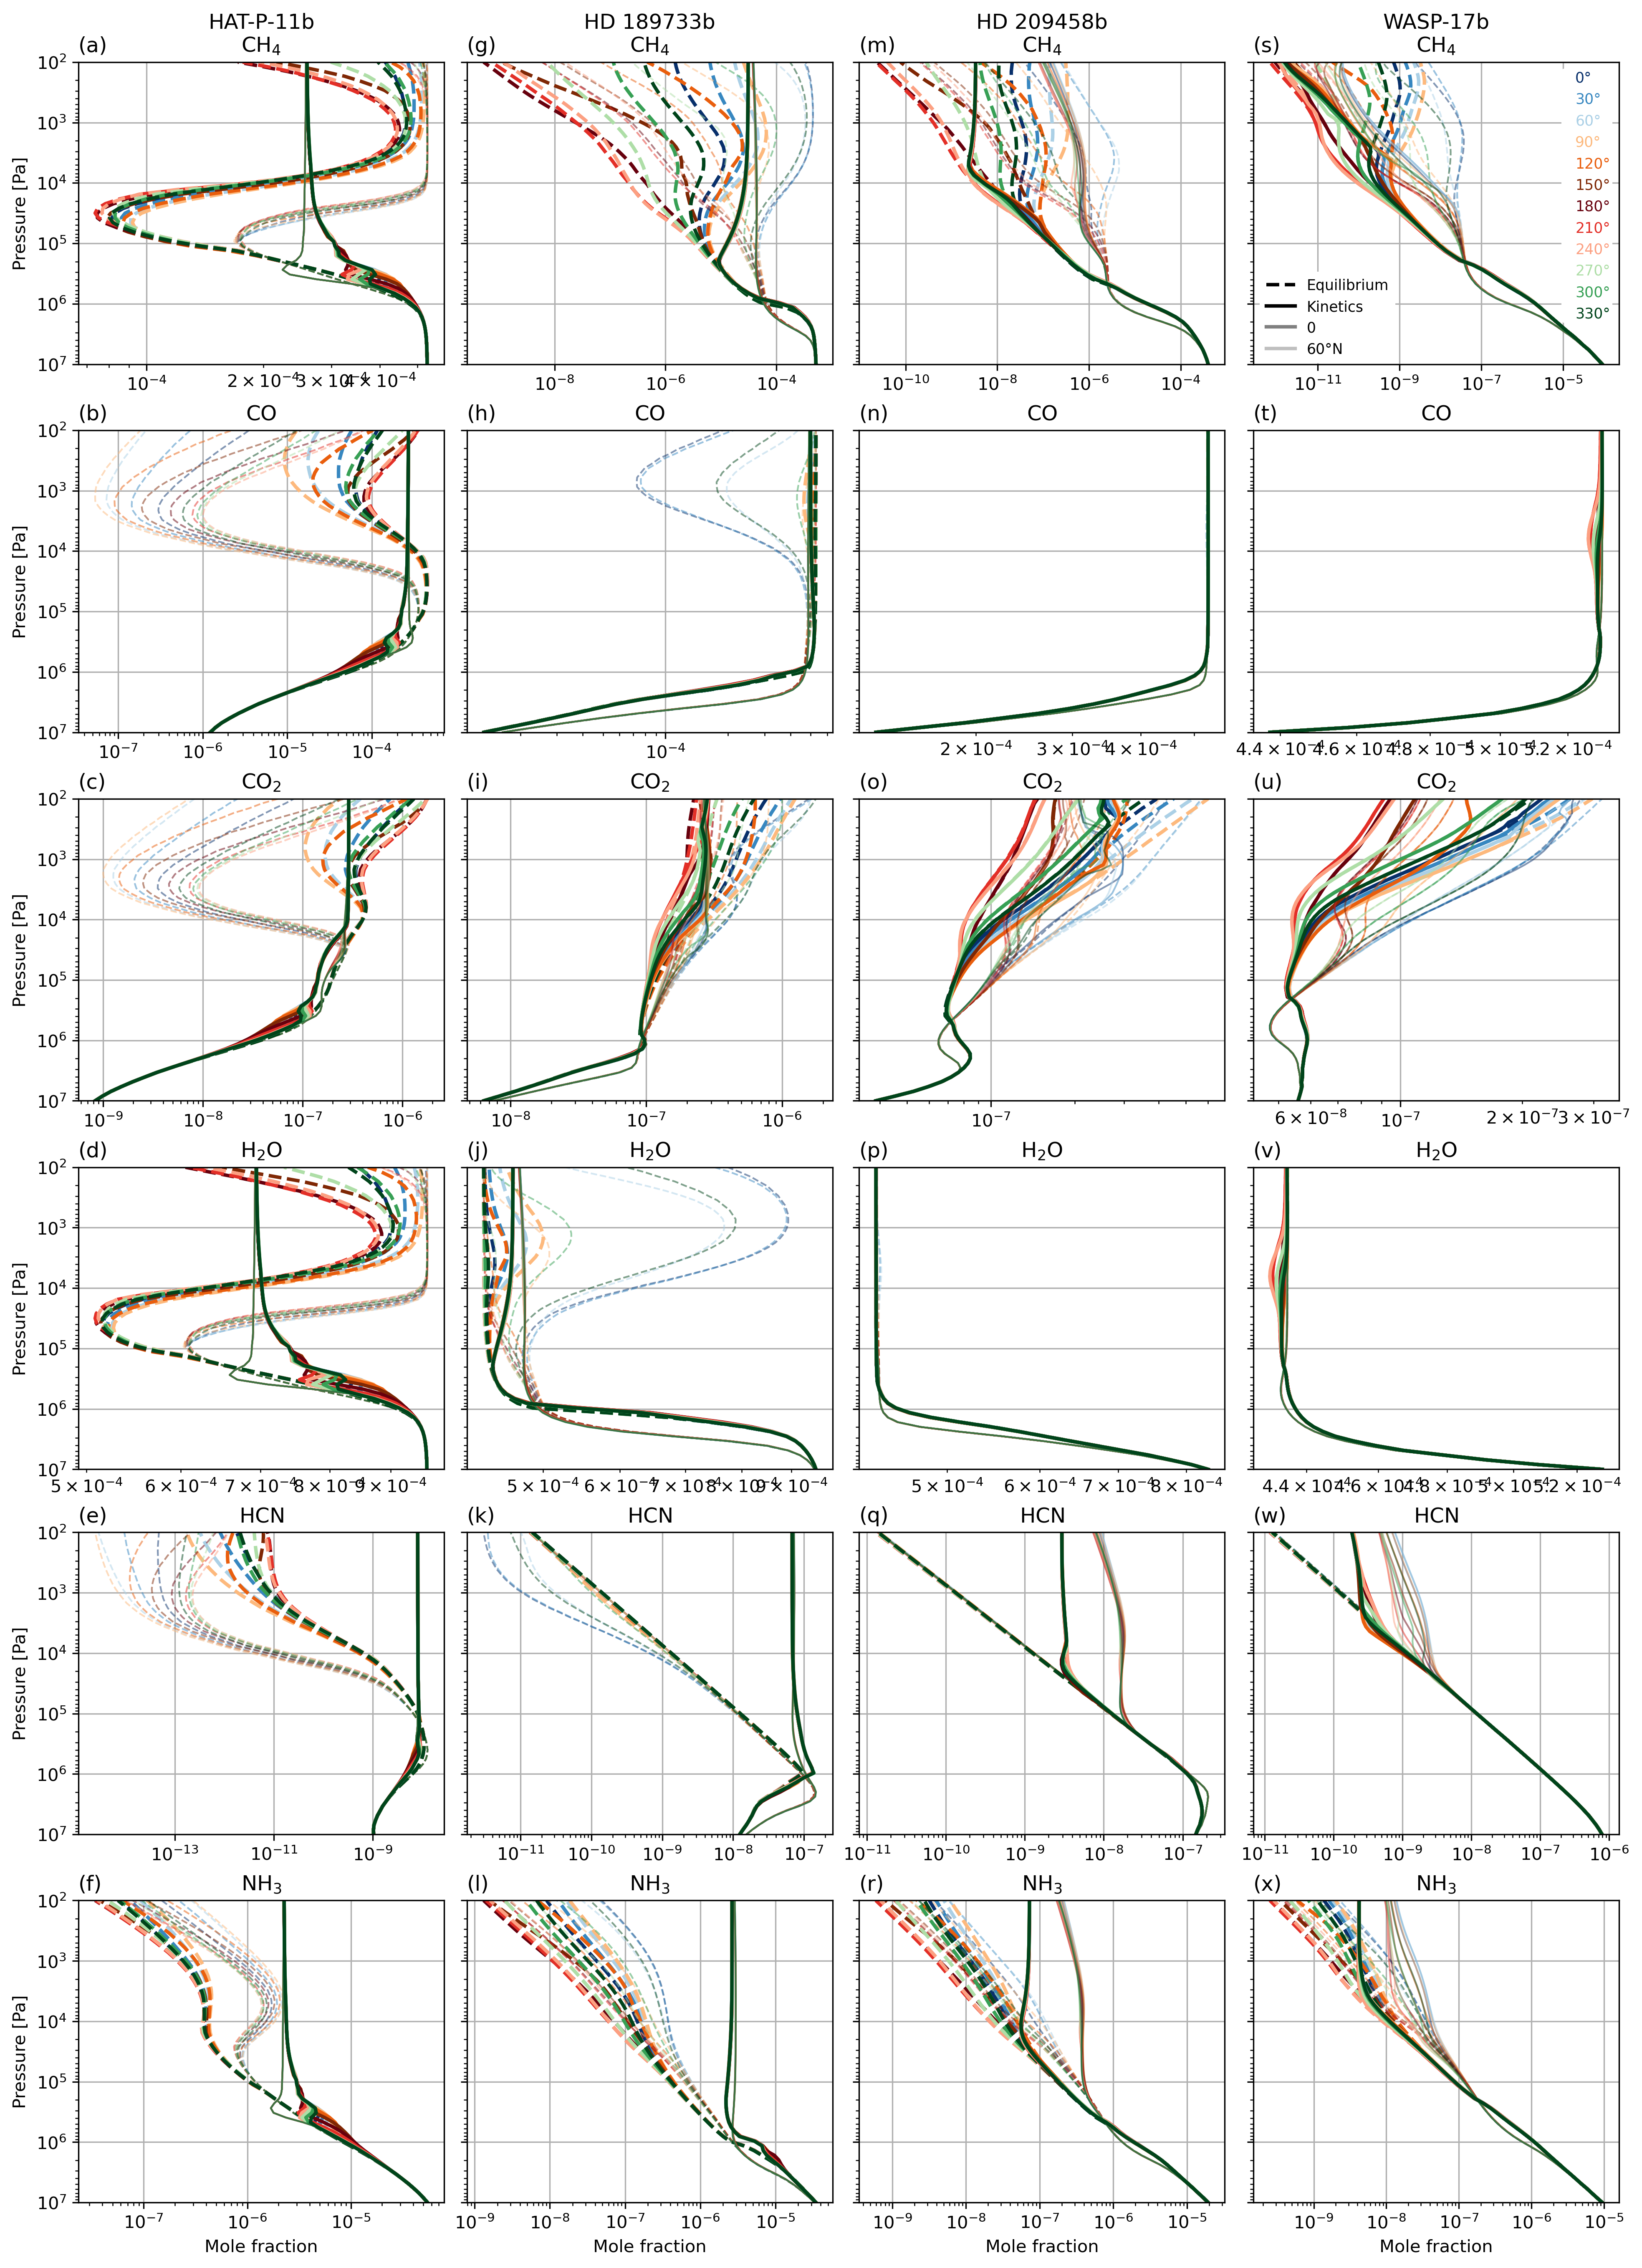

In [9]:
# Plot
fig, axes = plt.subplots(
    ncols=4,
    nrows=len(sp_names_short),
    figsize=(13, 18),
    #     sharex=True,
    sharey=True,
    facecolor="w",
    constrained_layout=True,
)
iletters = subplot_label_generator()
for planet, axcol in zip(PLANETS.keys(), axes.T):
    for sp, ax in zip(sp_names_short, axcol):
        stash_name = f"{sp.upper()} mole fraction"
        ax.set_title(f"({next(iletters)})", loc="left")
        ax.set_xscale("log")
        ax.set_yscale("log")
        #         ax.set_xlim(1e-12, 1e-2)
        ax.set_ylim(1e7, 1e2)
        ax.grid()
        if ax.get_subplotspec().is_first_row():
            ax.set_title(f'{PLANETS[planet]["tex"]}\n{GASES[sp.upper()]["tex"]}', loc="center")
        else:
            ax.set_title(f'{GASES[sp.upper()]["tex"]}', loc="center")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Pressure [Pa]")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Mole fraction")
        for exp, plt_kw in leg_line_kw.items():
            for lon, clr, clr60 in zip(tgt_lons, lon_clrs, lon_clrs_60):
                vp00 = (
                    vrbls[planet][exp]["sps_plevs_locs"]
                    .extract(stash_name)[0]
                    .extract(iris.Constraint(latitude=0, longitude=lon))
                )
                vp60 = (
                    vrbls[planet][exp]["sps_plevs_locs"]
                    .extract(stash_name)[0]
                    .extract(iris.Constraint(latitude=60, longitude=lon))
                )
                ax.plot(
                    vp00.data,
                    pres_coord.points,
                    **plt_kw,
                    color=clr,
                    label=f"{int(lon-1.25)}°",
                    linewidth=2,
                )
                ax.plot(
                    vp60.data,
                    pres_coord.points,
                    **plt_kw,
                    color=clr60,
                    label=f"{int(lon-1.25)}°",
                    linewidth=1,
                )
# Add extra legends
add_custom_legend(
    axes[0, 3],
    leg_exp_kw,
    loc="center left",
    bbox_to_anchor=(0, 0.225),
    frameon=True,
    fontsize="small",
    facecolor="white",
    edgecolor="white",
    framealpha=1,
)
add_custom_legend(
    axes[0, 3],
    leg_lat_kw,
    loc="center left",
    bbox_to_anchor=(0, 0.085),
    frameon=True,
    fontsize="small",
    facecolor="white",
    edgecolor="white",
    framealpha=1,
)
# Add longitudes legend
# Delete repeating handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
i = 1
while i < len(labels):
    if labels[i] in labels[:i]:
        del labels[i]
        del handles[i]
    else:
        i += 1
leg = axes[0, 3].legend(
    handles,
    labels,
    loc="upper right",
    frameon=True,
    handlelength=0,
    fontsize="small",
    facecolor="white",
    edgecolor="white",
    framealpha=1,
    borderpad=0.1,
)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
# Save
fig.savefig(path_to_results / "vertical_profiles" / f"pres_chem_vp_xaxis_diff_w_grid.png", bbox_inches="tight")